# Evolutionary Camouflage Versus a Learning Predator
EvoCamoVsLearningPredator.ipynb

Just a copy of Evo_Camo_vs_Static_FCD.ipynb as of 20220403


In [6]:
# Shared "communication" directory on Drive.
shared_directory = '/content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/'

# Pathname of pre-trained Keras/TensorFlow model
saved_model_directory = '/content/drive/My Drive/PredatorEye/saved_models/'
# trained_model = saved_model_directory + '20220202_1211_Find_3_Disks_complex'
# trained_model = saved_model_directory + '20220222_1747_F3D_augmented_rc4'
# trained_model = saved_model_directory + '20220227_0746_F3D2_a'
# trained_model = saved_model_directory + '20220304_1135_FCD5_a'
trained_model = saved_model_directory + '20220321_1711_FCD6_rc4'
model = []

my_prefix = "find_"
other_prefix = "camo_"

my_suffix =  ".txt"
# other_suffix = ".jpeg"
other_suffix = ".png"

fcd_image_size = 1024
fcd_disk_size = 201

import time
import PIL
from os import listdir
from os import remove
from os.path import join
from os.path import split
from os.path import isfile
from tensorflow import keras

# from PIL import Image
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
print('TensorFlow version:', tf.__version__)

from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# Import DiskFind utilities for PredatorEye.
import sys
sys.path.append('/content/drive/My Drive/PredatorEye/shared_code/')
import DiskFind as df

TensorFlow version: 2.8.0


# Ad hoc “predator server”

In [7]:
# Top level: wait for camo_xxx.jpeg files to appear, respond with find_xxx.txt
def start_run(step = 0):
    if step == 0:
        print('Start run in', shared_directory )
        list_unexpected_files(shared_directory)
    else:
        print('Continue run at step', step, ' in', shared_directory)
    while True:
        performStep(step, shared_directory)
        step += 1

# Continue from from the last camo_xxx.jpeg file.
def restart_run():
    start_run(newest_file_from_other(shared_directory))

# Single step: wait for camo file, write response, delete previous response.
def performStep(step, directory):
    waitForReply(step, shared_directory)
    print('Write file', step)
    writeResponseFile(step, shared_directory)
    deleteMyFile(step - 1, shared_directory)

# Read image file for step, apply pre-trained model, write response file.
def writeResponseFile(step, directory):
    # Read image file and check for expected format.
    image_pathname = makeOtherPathname(step, directory)
    pixel_tensor = df.read_image_file_as_pixel_tensor(image_pathname)
    assert df.check_pixel_tensor(pixel_tensor), ('wrong file format: ' +
                                                 image_pathname)
    # Run pre-trained model on new image.
    # predict = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
    prediction = model.predict(tf.convert_to_tensor([pixel_tensor]))[0]
    # Generate response file.
    # response_string = str(predict[0]) + " " + str(predict[1])
    response_string = str(prediction[0]) + " " + str(prediction[1])
    print('response_string ' + "'" + response_string + "'")
    file = open(makeMyPathname(step, directory),"w")
    file.write(response_string)
    file.close()
    print("wrote response file", makeMyPathname(step, directory))
    ############################################################################

    # 20220408
    label_for_fine_tuning = center_of_nearest_prey(prediction, step, directory)

    # 20220409
    df.draw_image(pixel_tensor, label_for_fine_tuning, prediction)

    ############################################################################

# Delete the given file, usually after having written the next one.
def deleteMyFile(step, directory):
    path = makeMyPathname(step, directory)
    if isfile(path):
        remove(path)

# From pathname for file of given step number from the "other" agent.
def makeOtherPathname(step, directory):
    return directory + other_prefix + str(step) + other_suffix

# Form pathname for file of given step number from "this" agent.
def makeMyPathname(step, directory):
    return directory + my_prefix + str(step) + my_suffix

################################################################################
def makePreyPathname(step, directory):
    return directory + 'prey_' + str(step) + '.txt'
################################################################################

# Wait until other agent's file for given step appears.
def waitForReply(step, directory):
    print('start waiting for  ', makeOtherPathname(step, directory))
    start_time = time.time()
    while not isFilePresent(makeOtherPathname(step, directory)):
        time.sleep(2)  # wait 2 sec
    print('done waiting for   ', makeOtherPathname(step, directory))
    print('Elapsed time:', int(time.time() - start_time), 'seconds.')

# Like fs::exists() but for unknown reasons, that does not
# seem to work for newly created files on G Drive.
#
# TODO Why? This version works on G Drive, but it seems simply
#      calling fs::exists() should be enough.
#
def isFilePresent(file):
    result = False
    (directory, filename) = split(file)
    for i in listdir(directory):
        if i == filename:
            result = True
    return result

# Actually I guess the counterparty may have already written its first...
def list_unexpected_files(directory):
    directory_contents = listdir(directory)
    if directory_contents:
        print('Unexpected files:', directory_contents)

# Returns the step number of the newest file from "other" in given directory.
# (So if "camo_573.jpeg" is the only "other" file there, returns int 573)
def newest_file_from_other(directory):
    steps = [0]  # Default to zero in case dir is empty.
    for filename in listdir(directory):
        if other_prefix == filename[0:len(other_prefix)]:
            steps.append(int(filename.split(".")[0].split("_")[1]))
    return max(steps)

################################################################################

# 20220408 
# Given the xy prediction from the current predator model, read the ground truth
# prey locations in the "prey_n.txt" file, return the one nearest to the current
# prediction. Effectively, assume the predator was "aiming for" that one but
# missed by a bit.
def center_of_nearest_prey(predict, step, directory):
    prey_centers = read_3_centers_from_file(step, directory)
    # print('prey_centers =\n', prey_centers)
    print('prey_centers =\n' + str(prey_centers))
    print('predict =', predict)
    print('type(predict) =', type(predict))

    # SURELY there is a more "pythonic" way to do this (select min distance)
    min_distance = float('inf')
    nearest_center = []
    for prey_center in prey_centers:
        print('prey_center =', prey_center)
        distance = df.dist2d(prey_center, predict)
        print('distance =', distance)
        if min_distance > distance:
            min_distance = distance
            nearest_center = prey_center
        print('min_distance =', min_distance)
        print('nearest_center =', nearest_center)

    return nearest_center

# TODO 20220408
# Read ground truth prey center location data provided in "prey_n.txt" file.
def read_3_centers_from_file(step, directory):
    # Read contents of file as string.
    file = open(makePreyPathname(step, directory),'r')
    prey_centers_string = file.read()
    file.close()
    # Split string at whitespace, map to 6 floats, reshape into 3 xy pairs.
    return np.reshape(list(map(float, prey_centers_string.split())), (3, 2))


################################################################################

# Read pre-trained model

In [8]:
# Read pre-trained TensorFlow "predator vision" model.

print('Reading pre-trained model from:', trained_model)
# ad hoc workaround suggested on https://stackoverflow.com/q/66408995/1991373
#
# dependencies = {
#     'hamming_loss': tfa.metrics.HammingLoss(mode="multilabel", name="hamming_loss"),
#     'attention': attention(return_sequences=True)
# }
#
# dependencies = {
#     'valid_accuracy': ValidAccuracy
# }

# Calculates RELATIVE disk radius on the fly -- rewrite later.
def fcd_disk_radius():
    return (float(fcd_disk_size) / float(fcd_image_size)) / 2

# Given two tensors of 2d point coordinates, return a tensor of the Cartesian
# distance between corresponding points in the input tensors.
def corresponding_distances(y_true, y_pred):
    true_pos_x, true_pos_y = tf.split(y_true, num_or_size_splits=2, axis=1)
    pred_pos_x, pred_pos_y = tf.split(y_pred, num_or_size_splits=2, axis=1)
    dx = true_pos_x - pred_pos_x
    dy = true_pos_y - pred_pos_y
    distances = tf.sqrt(tf.square(dx) + tf.square(dy))
    return distances

# 20211231 copied from Find_Concpocuous_Disk
def in_disk(y_true, y_pred):
    distances = corresponding_distances(y_true, y_pred)
    # relative_disk_radius = (float(fcd_disk_size) / float(fcd_image_size)) / 2

    # From https://stackoverflow.com/a/42450565/1991373
    # Boolean tensor marking where distances are less than relative_disk_radius.
    # insides = tf.less(distances, relative_disk_radius)
    insides = tf.less(distances, fcd_disk_radius())
    map_to_zero_or_one = tf.cast(insides, tf.int32)
    return map_to_zero_or_one

dependencies = { 'in_disk': in_disk }

model = keras.models.load_model(trained_model, custom_objects=dependencies)

Reading pre-trained model from: /content/drive/My Drive/PredatorEye/saved_models/20220321_1711_FCD6_rc4


# Run test

Start run in /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/
start waiting for   /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_0.png
done waiting for    /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_0.png
Elapsed time: 32 seconds.
Write file 0
response_string '0.5518122 0.45771062'
wrote response file /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/find_0.txt
prey_centers =
[[0.554164 0.199219]
 [0.572027 0.493651]
 [0.748673 0.728154]]
predict = [0.5518122  0.45771062]
type(predict) = <class 'numpy.ndarray'>
prey_center = [0.554164 0.199219]
distance = 0.2585023223098366
min_distance = 0.2585023223098366
nearest_center = [0.554164 0.199219]
prey_center = [0.572027 0.493651]
distance = 0.04123529943244471
min_distance = 0.04123529943244471
nearest_center = [0.572027 0.493651]
prey_center = [0.748673 0.728154]
distance = 0.33450531443957043
min_distance = 0.04123529943244471
nearest_center = [0.572027 0.493651]


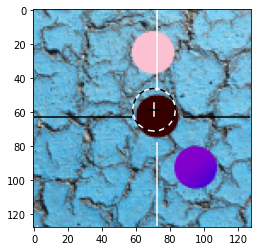

start waiting for   /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_1.png
done waiting for    /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_1.png
Elapsed time: 40 seconds.
Write file 1
response_string '0.43212608 0.58616525'
wrote response file /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/find_1.txt
prey_centers =
[[0.653003 0.656905]
 [0.682675 0.259313]
 [0.230464 0.749727]]
predict = [0.43212608 0.58616525]
type(predict) = <class 'numpy.ndarray'>
prey_center = [0.653003 0.656905]
distance = 0.23192828267986498
min_distance = 0.23192828267986498
nearest_center = [0.653003 0.656905]
prey_center = [0.682675 0.259313]
distance = 0.41183389455893404
min_distance = 0.23192828267986498
nearest_center = [0.653003 0.656905]
prey_center = [0.230464 0.749727]
distance = 0.2596536900981806
min_distance = 0.23192828267986498
nearest_center = [0.653003 0.656905]


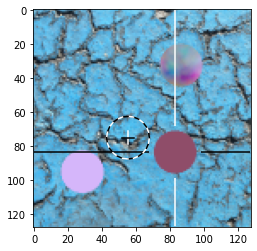

start waiting for   /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_2.png
done waiting for    /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_2.png
Elapsed time: 40 seconds.
Write file 2
response_string '0.7715953 0.80072635'
wrote response file /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/find_2.txt
prey_centers =
[[0.800781 0.792456]
 [0.634895 0.546888]
 [0.678735 0.248005]]
predict = [0.7715953  0.80072635]
type(predict) = <class 'numpy.ndarray'>
prey_center = [0.800781 0.792456]
distance = 0.030334862550026445
min_distance = 0.030334862550026445
nearest_center = [0.800781 0.792456]
prey_center = [0.634895 0.546888]
distance = 0.2883069229776268
min_distance = 0.030334862550026445
nearest_center = [0.800781 0.792456]
prey_center = [0.678735 0.248005]
distance = 0.5604675998470455
min_distance = 0.030334862550026445
nearest_center = [0.800781 0.792456]


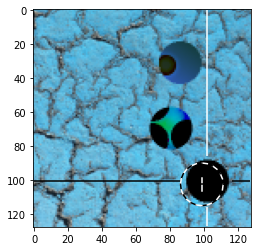

start waiting for   /content/drive/My Drive/PredatorEye/evo_camo_vs_static_fcd/camo_3.png


KeyboardInterrupt: ignored

In [9]:
# Normally start from step 0, or if an "other" file exists
# (eg 'camo_123.jpeg') then restart from that point.
restart_run()